# Creating Dummy Data

In [1]:
import numpy as np
import pandas as pd

# Number of total campaigns
total_campaigns = 500

# Number of Travel campaigns (23% of total)
num_travel = int(total_campaigns * 0.23)
num_retail = total_campaigns - num_travel

# Generate Spend values with noise
spend_retail = np.random.randint(500, 80000, num_retail) + np.random.normal(1, 5000, num_retail)
spend_travel = np.random.randint(500, 6 * 80000, num_travel) + np.random.normal(1, 10000, num_travel)

# Ensure spend values are non-negative
spend_retail = np.clip(spend_retail, 500, None).round(2)
spend_travel = np.clip(spend_travel, 500, None).round(2)

# Static dummy data
data = pd.DataFrame({
    'CampaignID': np.arange(1, total_campaigns + 1),
    'Industry': ['Industry B'] * num_travel + ['Industry A'] * num_retail,
    'Campaign Type': np.random.choice(['Type A', 'Type B'], total_campaigns),
    'Spend': np.concatenate([spend_travel, spend_retail]),

})



# Generate Displays based on Spend
# Higher spend results in higher displays, within a defined range
data['Displays'] = data['Spend'].apply(
    lambda spend: np.random.randint(max(1, int(spend / 2)), max(2, int(spend * 2)))
)

def generate_clicks(row):
    if row['Displays'] == 0:
        return 0
    base_clicks = row['Displays'] * (0.1 if row['Campaign Type'] == 'Type A' else 0.02)
    noise = np.random.normal(0, total_campaigns)
    clicks = max(0, base_clicks + noise)
    return int(clicks)

data['Clicks'] = data.apply(generate_clicks, axis=1)



def generate_orders(row):
    if row['Clicks'] == 0:
        return 0
    base_orders = row['Clicks'] * (0.1 if row['Industry'] == 'Industry B' else np.random.uniform(0.1, 0.3))
    noise = np.random.normal(0, 5) 
    orders = max(0, base_orders + noise)
    return int(orders)

data['Orders'] = data.apply(generate_orders, axis=1)


# Shuffle the data to mix 'Industry T' and 'Industry R'
data = data.sample(frac=1).reset_index(drop=True)


def generate_sales(row):
    if row['Orders'] == 0:
        return 0
    multiplier = np.random.uniform(50, 1500) if row['Industry'] == 'Industry B' else np.random.uniform(50, 200)
    base_sales = row['Orders'] * multiplier
    noise = np.random.normal(100, 1000)  
    sales = max(row['Orders'] + 1, base_sales + noise)
    return np.round(sales, 2)

data['Sales'] = data.apply(generate_sales, axis=1)

def generate_campaign_duration(spend):
    base_duration = np.random.randint(5, 120)
    correlation = np.random.normal(0.0001, 0.00005) * spend
    duration = base_duration + correlation
    return int(np.clip(duration, 5, 120))

data['CampaignDuration'] = data['Spend'].apply(generate_campaign_duration)

data['CTR'] = data['Clicks'] / data['Displays']
data['CR'] = data['Orders'] / data['Clicks']
data['AOV'] = data['Sales'] / data['Orders']
data['CPC'] = data['Spend'] / data['Clicks']
data['CPO'] = data['Spend'] / data['Orders']

data['ROI'] = data['Sales'] / data['Spend']

data.replace([np.inf, -np.inf], np.nan, inplace=True)

data.head()


,CampaignID,Industry,Campaign Type,Spend,Displays,Clicks,Orders,Sales,CampaignDuration,CTR,CR,AOV,CPC,CPO,ROI
0,272,Industry A,Type B,68685.33,85548,1120,110,14469.19,62,0.013092,0.098214,131.538091,61.326188,624.412091,0.210659
1,98,Industry B,Type B,423139.00,357790,7089,700,130173.96,120,0.019813,0.098745,185.962800,59.689519,604.484286,0.307639
2,138,Industry A,Type B,33599.28,60803,548,146,17509.08,12,0.009013,0.266423,119.925205,61.312555,230.132055,0.521115
3,23,Industry B,Type B,280598.21,418176,7991,794,362821.02,91,0.019109,0.099362,456.953426,35.114280,353.398249,1.293027
4,42,Industry B,Type A,291678.25,326292,32149,3211,2907798.19,72,0.098528,0.099879,905.574024,9.072701,90.837200,9.969198


In [2]:
data.to_csv('dummy_data.csv', index=False)

# Anonymizing Actual Data

In [3]:
data = pd.read_csv('data_with_metrics.csv')
del data['client_country_level_3_name']
del data['region']
del data['global_account_name']
del data['campaign_name']
del data['audience_id']
del data['audience_name']
del data['client_country_code']
del data['campaign_status']
del data['included_segment_types']

In [4]:
df = data.copy()

df.rename(columns={
    'campaign_product_taxonomy_label': 'campaign_type',
    'vertical_level_1_name': 'industry'
}, inplace=True)


In [5]:
# Create a dictionary of pseudonyms
pseudonyms = {name: f"Client-{i+1}" for i, name in enumerate(df['client_name'].unique())}

# Apply the pseudonyms to the client_name column
df['client_name'] = df['client_name'].map(pseudonyms)



In [6]:
df['campaign_id'] = df['campaign_id'].astype(int)
df['campaign_id'] = df['campaign_id'].apply(lambda x: x + 5123)
df['campaign_id'] = df['campaign_id'].astype(str)


replacements = {'0': 'A', '3': 'J', '7': 'P', '8': 'S'}
df['campaign_id'] = df['campaign_id'].replace(replacements, regex=True)



In [7]:
def extract_campaign_type(campaign_type):
    if campaign_type == 'commerce growth - acquisition':
        return 'Video Campaign'
    elif campaign_type == 'commerce growth - retention retargeting':
        return 'Image Campaign'
    else:
        return 'type C'


df['campaign_type'] = df['campaign_type'].apply(extract_campaign_type, 1)


C:\Users\j.sclar\AppData\Local\Temp\ipykernel_19384\82813617.py:10: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df['campaign_type'] = df['campaign_type'].apply(extract_campaign_type, 1)


In [8]:
def extract_industry(industry):
    travel = ['ONLINE TRAVEL AGENTS', 'HOTELS/RESORTS', 'TRAVEL SERVICES', 'AIRLINES']
    if industry in travel:
        return 'Transportation'
    else:
        return 'Robotics'


df['industry'] = df['industry'].apply(extract_industry, 1)


C:\Users\j.sclar\AppData\Local\Temp\ipykernel_19384\614414139.py:9: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df['industry'] = df['industry'].apply(extract_industry, 1)


In [9]:
columns_to_scale  = ["clicks","displays","spend","sales","order_value_euro","visits"]
scaling_factor = .85

df[columns_to_scale] = (df[columns_to_scale] * scaling_factor).round(0)



In [10]:
from pandas.tseries.offsets import DateOffset

# Convert columns to datetime
df['start_day'] = pd.to_datetime(df['start_day'])
df['end_day'] = pd.to_datetime(df['end_day'])

# Define the offset
offset = DateOffset(months=4, days=9)

# Apply the offset to start_day and end_day
df['start_day'] = df['start_day'] - offset
df['end_day'] = df['end_day'] - offset



In [11]:
df = df[df["campaign_type"] != "type C"]

In [12]:
df.to_csv('data_anonymized.csv', index=False)

data_with_metrics = pd.read_csv("")

In [13]:
data_with_metrics = pd.read_csv('data_anonymized.csv')


In [14]:
data_with_metrics.head()

,client_name,campaign_id,campaign_type,industry,clicks,displays,spend,sales,order_value_euro,visits,start_day,end_day,CTR,CR,landing_rate,AOV,CPC,CPV,CPO,ROI
0,Client-1,24A544,Image Campaign,Robotics,1618830.0,162603405.0,78109.0,10186.0,443171.0,1291189.0,2022-01-23,2023-08-12,0.009956,0.006292,0.797606,43.509776,0.048250,0.060494,7.668582,5.673771
1,Client-2,JJ6699,Image Campaign,Robotics,105562.0,15219833.0,3965.0,1910.0,146299.0,66598.0,2022-04-08,2024-01-05,0.006936,0.018093,0.630896,76.598333,0.037563,0.059538,2.076057,36.896065
2,Client-3,2P5J6S,Video Campaign,Robotics,56336.0,14661070.0,695.0,41.0,4058.0,2067.0,2023-04-16,2023-05-15,0.003843,0.000724,0.036694,99.450347,0.012335,0.336151,17.031644,5.839151
3,Client-4,1JA664,Image Campaign,Robotics,305343.0,24570448.0,59482.0,32772.0,1022299.0,266359.0,2022-01-23,2023-01-15,0.012427,0.107328,0.872329,31.194530,0.194803,0.223314,1.815029,17.186793
4,Client-5,414A95,Video Campaign,Robotics,25362.0,1944225.0,3267.0,4.0,439.0,8650.0,2023-07-02,2023-08-09,0.013045,0.000168,0.341042,103.368907,0.128811,0.377699,768.693791,0.134473


In [15]:
image_data = data_with_metrics[data_with_metrics['campaign_type'] == 'Image Campaign']
video_data = data_with_metrics[data_with_metrics['campaign_type'] == 'Video Campaign']

In [16]:
image_data_transportation = video_data[video_data['industry'] == 'Transportation']
image_data_robotics = video_data[video_data['industry'] == 'Robotics']

In [17]:
# Convert 'start_day' to datetime in both dataframes
image_data_robotics['start_day'] = pd.to_datetime(image_data_robotics['start_day'])
image_data_transportation['start_day'] = pd.to_datetime(image_data_transportation['start_day'])

# Filter by year and group by 'client_name'
spend_2022_transportation = image_data_transportation[image_data_transportation['start_day'].dt.year == 2022].groupby('client_name')['spend'].sum().reset_index()
spend_2023_transportation = image_data_transportation[image_data_transportation['start_day'].dt.year == 2023].groupby('client_name')['spend'].sum().reset_index()

# Merge the results
result_transportation = pd.merge(spend_2022_transportation, spend_2023_transportation, on='client_name', how='outer', suffixes=('_2022', '_2023')).fillna(0)

# Identify churned clients
result_transportation['churned'] = result_transportation.apply(lambda row: row['spend_2022'] > 0 and row['spend_2023'] == 0, axis=1)

result_transportation

C:\Users\j.sclar\AppData\Local\Temp\ipykernel_19384\1771863025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_data_robotics['start_day'] = pd.to_datetime(image_data_robotics['start_day'])
C:\Users\j.sclar\AppData\Local\Temp\ipykernel_19384\1771863025.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_data_transportation['start_day'] = pd.to_datetime(image_data_transportation['start_day'])


,client_name,spend_2022,spend_2023,churned
0,Client-101,7313.0,3226.0,False
1,Client-1011,25071.0,0.0,True
2,Client-1018,24701.0,0.0,True
3,Client-102,30387.0,0.0,True
4,Client-1034,2673.0,13658.0,False
...,...,...,...,...
394,Client-922,0.0,12585.0,False
395,Client-939,0.0,7673.0,False
396,Client-966,0.0,13440.0,False
397,Client-971,0.0,9940.0,False


In [18]:
# Convert 'start_day' to datetime
image_data_robotics['start_day'] = pd.to_datetime(image_data_robotics['start_day'])

# Filter by year and group by 'client_name'
spend_2022_robotics = image_data_robotics[image_data_robotics['start_day'].dt.year == 2022].groupby('client_name')['spend'].sum().reset_index()
spend_2023_robotics = image_data_robotics[image_data_robotics['start_day'].dt.year == 2023].groupby('client_name')['spend'].sum().reset_index()

# Merge the results
result_robotics = pd.merge(spend_2022_robotics, spend_2023_robotics, on='client_name', how='outer', suffixes=('_2022', '_2023')).fillna(0)

result_robotics['churned'] = result_robotics.apply(lambda row: row['spend_2022'] > 0 and row['spend_2023'] == 0, axis=1)

result_robotics

C:\Users\j.sclar\AppData\Local\Temp\ipykernel_19384\3051946309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_data_robotics['start_day'] = pd.to_datetime(image_data_robotics['start_day'])


,client_name,spend_2022,spend_2023,churned
0,Client-1,18617.0,0.0,True
1,Client-1000,100485.0,34581.0,False
2,Client-1001,23265.0,0.0,True
3,Client-1005,2490.0,0.0,True
4,Client-1007,6225.0,0.0,True
...,...,...,...,...
1896,Client-978,0.0,1415.0,False
1897,Client-987,0.0,476.0,False
1898,Client-988,0.0,247.0,False
1899,Client-995,0.0,17598.0,False


In [19]:
result_transportation_2022_filtred = result_transportation[result_transportation['spend_2022'] > 0]
result_transportation_2023_filtred = result_transportation[result_transportation['spend_2023'] > 0]

median_spend_2022_transportation = result_transportation_2022_filtred['spend_2022'].median()
median_spend_2023_transportation = result_transportation_2023_filtred['spend_2023'].median()

churned_denominator = result_transportation[result_transportation['spend_2022'] > 0].shape[0]

transportation_churned = len(result_transportation[result_transportation['churned'] == True]) / churned_denominator

tranposrtation_df = pd.DataFrame({
    "2022 median spend": [median_spend_2022_transportation],
    "2023 median spend": [median_spend_2023_transportation],
    "churned": [transportation_churned]

}, index=["transportation"])

tranposrtation_df

,2022 median spend,2023 median spend,churned
transportation,9518.0,3985.0,0.675


In [20]:
result_robotics_2022_filtred = result_robotics[result_robotics['spend_2022'] > 0]
result_robotics_2023_filtred = result_robotics[result_robotics['spend_2023'] > 0]

median_spend_2022_robotics = result_robotics_2022_filtred['spend_2022'].median()
median_spend_2023_robotics = result_robotics_2023_filtred['spend_2023'].median()

churned_denominator = result_robotics[result_robotics['spend_2022'] > 0].shape[0]

robotics_churned = len(result_robotics[result_robotics['churned'] == True]) / churned_denominator

robotics_df = pd.DataFrame({
    "2022 median spend": [median_spend_2022_robotics],
    "2023 median spend": [median_spend_2023_robotics],
    "churned": [robotics_churned]

}, index=["robotics"])

robotics_df

,2022 median spend,2023 median spend,churned
robotics,6322.0,3599.5,0.70895


In [21]:
tranposrtation_df.loc["robotics"] = [median_spend_2022_robotics, median_spend_2023_robotics, robotics_churned]
tranposrtation_df

,2022 median spend,2023 median spend,churned
transportation,9518.0,3985.0,0.67500
robotics,6322.0,3599.5,0.70895


In [22]:
churn_df = tranposrtation_df.copy()

churn_df['median spend difference'] = churn_df['2023 median spend'] - churn_df['2022 median spend']
churn_df

,2022 median spend,2023 median spend,churned,median spend difference
transportation,9518.0,3985.0,0.67500,-5533.0
robotics,6322.0,3599.5,0.70895,-2722.5


In [23]:
churn_df.reset_index(inplace=True)
churn_df.rename(columns={'index': 'industry'}, inplace=True)


In [24]:
churn_df.to_csv('churn_data.csv', index=False)
churn_df

,industry,2022 median spend,2023 median spend,churned,median spend difference
0,transportation,9518.0,3985.0,0.67500,-5533.0
1,robotics,6322.0,3599.5,0.70895,-2722.5


In [25]:
data_anonymized = pd.read_csv('data_anonymized.csv')
data_anonymized


,client_name,campaign_id,campaign_type,industry,clicks,displays,spend,sales,order_value_euro,visits,start_day,end_day,CTR,CR,landing_rate,AOV,CPC,CPV,CPO,ROI
0,Client-1,24A544,Image Campaign,Robotics,1618830.0,162603405.0,78109.0,10186.0,443171.0,1291189.0,2022-01-23,2023-08-12,0.009956,0.006292,0.797606,43.509776,0.048250,0.060494,7.668582,5.673771
1,Client-2,JJ6699,Image Campaign,Robotics,105562.0,15219833.0,3965.0,1910.0,146299.0,66598.0,2022-04-08,2024-01-05,0.006936,0.018093,0.630896,76.598333,0.037563,0.059538,2.076057,36.896065
2,Client-3,2P5J6S,Video Campaign,Robotics,56336.0,14661070.0,695.0,41.0,4058.0,2067.0,2023-04-16,2023-05-15,0.003843,0.000724,0.036694,99.450347,0.012335,0.336151,17.031644,5.839151
3,Client-4,1JA664,Image Campaign,Robotics,305343.0,24570448.0,59482.0,32772.0,1022299.0,266359.0,2022-01-23,2023-01-15,0.012427,0.107328,0.872329,31.194530,0.194803,0.223314,1.815029,17.186793
4,Client-5,414A95,Video Campaign,Robotics,25362.0,1944225.0,3267.0,4.0,439.0,8650.0,2023-07-02,2023-08-09,0.013045,0.000168,0.341042,103.368907,0.128811,0.377699,768.693791,0.134473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14779,Client-4831,1PS92J,Image Campaign,Robotics,56818.0,14699594.0,32137.0,926.0,261808.0,38648.0,2022-01-23,2024-01-05,0.003865,0.016291,0.680200,282.837322,0.565611,0.831535,34.718315,8.146632
14780,Client-1135,J9S629,Image Campaign,Robotics,19429.0,4006747.0,3963.0,52.0,8443.0,3873.0,2023-06-04,2023-11-12,0.004849,0.002669,0.199361,162.840984,0.203989,1.023214,76.439108,2.130336
14781,Client-221,JSSJS9,Video Campaign,Transportation,58514.0,8422731.0,9830.0,9.0,9509.0,8306.0,2023-02-23,2023-04-25,0.006947,0.000160,0.141952,1017.008182,0.168002,1.183513,1051.389912,0.967299
14782,Client-1628,J6JJ1A,Image Campaign,Robotics,35386.0,12681300.0,43930.0,1153.0,262589.0,21976.0,2022-10-08,2024-01-05,0.002790,0.032573,0.621043,227.822799,1.241471,1.999012,38.113905,5.977419


In [26]:
image_transport = data_anonymized[(data_anonymized['campaign_type'] == 'Image Campaign') & (data_anonymized['industry'] == 'Transportation')]
image_robotics = data_anonymized[(data_anonymized['campaign_type'] == 'Image Campaign') & (data_anonymized['industry'] == 'Robotics')]

video_transport = data_anonymized[(data_anonymized['campaign_type'] == 'Video Campaign') & (data_anonymized['industry'] == 'Transportation')]
video_robotics = data_anonymized[(data_anonymized['campaign_type'] == 'Video Campaign') & (data_anonymized['industry'] == 'Robotics')]




In [27]:
metrics = ['CTR', 'CR', 'AOV', 'CPC', 'CPO', 'ROI' ]

In [28]:
group_data =  data_anonymized.groupby(['industry', 'campaign_type'])[metrics].median().reset_index()
group_data

,industry,campaign_type,CTR,CR,AOV,CPC,CPO,ROI
0,Robotics,Image Campaign,0.007586,0.011984,109.910298,0.230228,16.094468,6.992295
1,Robotics,Video Campaign,0.004633,0.000545,90.668702,0.087905,77.202927,0.652547
2,Transportation,Image Campaign,0.004828,0.006275,600.548570,0.346567,50.448242,9.045790
3,Transportation,Video Campaign,0.003646,0.000035,600.583623,0.148786,519.471853,0.074355


In [39]:
0.007586 * 2.590890

0.01965449154

In [44]:
def calculate_ratio(group):
    metrics = ['CTR', 'CR', 'AOV', 'CPC', 'CPO', 'ROI']
    ratios = {}
    for metric in metrics:
        image_campaign = group[group['campaign_type'] == 'Image Campaign'][metric].values[0]
        video_campaign = group[group['campaign_type'] == 'Video Campaign'][metric].values[0]
        ratios[metric + '_ratio'] = image_campaign / video_campaign
    return pd.Series(ratios)

# Apply the function to each industry group
ratios_df = group_data.groupby('industry').apply(calculate_ratio).reset_index()

In [45]:
ratios_df

,industry,CTR_ratio,CR_ratio,AOV_ratio,CPC_ratio,CPO_ratio,ROI_ratio
0,Robotics,1.637547,22.003823,1.212219,2.619062,0.208470,10.715388
1,Transportation,1.324168,178.029437,0.999942,2.329297,0.097114,121.657395


In [47]:
import pandas as pd

# Creating the DataFrame
data = {
    'industry': ['Robotics', 'Robotics', 'Transportation', 'Transportation'],
    'campaign_type': ['Image Campaign', 'Video Campaign', 'Image Campaign', 'Video Campaign'],
    'CTR': [0.007586, 0.004633, 0.004828, 0.003646],
    'CR': [0.011984, 0.000545, 0.006275, 0.000035],
    'AOV': [109.910298, 90.668702, 600.548570, 600.583623],
    'CPC': [0.230228, 0.087905, 0.346567, 0.148786],
    'CPO': [16.094468, 77.202927, 50.448242, 519.471853],
    'ROI': [6.992295, 0.652547, 9.045790, 0.074355]
}

df = pd.DataFrame(data)

# Function to calculate the ratio for each metric
def calculate_ratio(group):
    metrics = ['CTR', 'CR', 'AOV', 'CPC', 'CPO', 'ROI']
    ratios = {}
    for metric in metrics:
        image_campaign = group[group['campaign_type'] == 'Image Campaign'][metric].values[0]
        video_campaign = group[group['campaign_type'] == 'Video Campaign'][metric].values[0]
        ratios[metric + '_ratio'] = image_campaign / video_campaign
    return pd.Series(ratios)

# Apply the function to each industry group
ratios_df = df.groupby('industry').apply(calculate_ratio).reset_index()



ratios_df


,industry,CTR_ratio,CR_ratio,AOV_ratio,CPC_ratio,CPO_ratio,ROI_ratio
0,Robotics,1.637384,21.988991,1.212219,2.619055,0.208470,10.715389
1,Transportation,1.324191,179.285714,0.999942,2.329298,0.097114,121.656782


In [52]:
ratios_df.to_csv('ratios.csv', index=False)

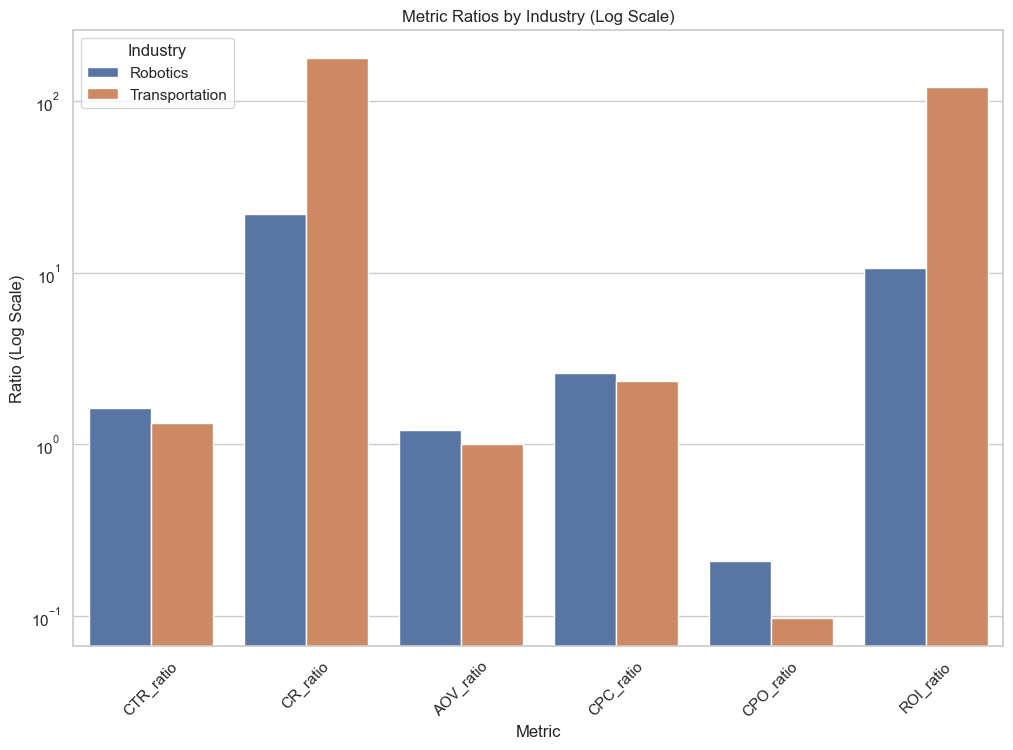

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the dataframe for plotting
ratios_melted = pd.melt(ratios_df, id_vars='industry', var_name='metric', value_name='ratio')

# Plot the ratios with log scale on y-axis
plt.figure(figsize=(12, 8))
sns.barplot(x='metric', y='ratio', hue='industry', data=ratios_melted)
plt.yscale('log')
plt.xticks(rotation=45)
plt.title('Metric Ratios by Industry (Log Scale)')
plt.ylabel('Ratio (Log Scale)')
plt.xlabel('Metric')
plt.legend(title='Industry')
plt.show()